In [49]:
import pandas as pd
import numpy as np
import re
# loading the sources files
from IPython.core.display import display, HTML
tp=pd.read_csv("20231211-Filtered-TPs.csv")
suppliermaster=pd.read_csv("20231221-supplier-master.csv")

#For future reference
leninitp=len(tp)
leninisuppliermaster=len(suppliermaster)



/tmp/ipykernel_96/1603585325.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/tmp/ipykernel_96/1603585325.py:7: DtypeWarning: Columns (0,11,16,23,24,30,35,47) have mixed types. Specify dtype option on import or set low_memory=False.
  suppliermaster=pd.read_csv("20231221-supplier-master.csv")


In [50]:
#Read third party, filter on AC division
# Filtrage uniquement sur les third party AC
display(HTML('<h1>Stats</h1>'))
display(HTML('<b>Third to match # : </b>'+str(leninitp)))
display(HTML('<b>Supplier in referential # : </b>'+str(leninisuppliermaster)))


In [51]:
# The country file is used to provide a mapping to all country representation (language and typo). 
countries=pd.read_csv("countries.csv",index_col=0)
# Select the countries when there is a need to substitute
replacements=countries[countries.originalcountry!=countries.tobename]
# Convert the mapping adding some pattern to avoid unwanted replacement 
# (To avoid Airbus is replaced by Airbus Airbusa because us represent the coutry usa)
#replacements.originalcountry="[\\s^]"+replacements.originalcountry+"[\\s$]"
replacements.originalcountry=replacements.originalcountry
replacements.tobename=" "+replacements.tobename
# Replacement of countries to unifed representation (independant from tongue and typo)
replacements=replacements.set_index('originalcountry')
replacements.tobename=replacements.tobename.replace("\s","",regex=True)
# Converting to dict
replacements=replacements.tobename.to_dict()

# Create a single pattern doing all replacement to apply once on every line (for efficency)
rep = dict((re.escape(k), v) for k, v in replacements.items()) 
pattern = re.compile("|".join(rep.keys()))


/tmp/ipykernel_96/1498682475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacements.originalcountry=replacements.originalcountry
/tmp/ipykernel_96/1498682475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacements.tobename=" "+replacements.tobename


In [52]:
# This set the country in case where the county information is provided in the name of the thrid party
def deduceContryFromNameInformation(df,acronym,country):
    df.CountryCleansed=df.CountryCleansed.mask((df.CountryCleansed.isna()) & (df.NameCleansed.str.contains( "\\s"+acronym+"[\s]*")),country)
    df.NameCleansed=df.NameCleansed.str.replace("\\s"+acronym+"[\\s]*"," ",regex=True)
    return df
    
def removeFromName(df,toremove):
    df.NameCleansed=df.NameCleansed.str.replace("\\s"+toremove+"[\\s]*"," ",regex=True)
    return df

def removeFromNameCountry(df,toremove):
    df.NameCountryCleansed=df.NameCountryCleansed.str.replace("\\s"+toremove+"[\\s]*"," ",regex=True)
    return df

# Function to clean the name of the commany and creating a column for representation of name + country
def cleanCountryAndName(df):
    dftoreplace=df
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"sas","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"s\.a\.s","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"france","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"french","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"ltd","united kingdom")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"limited","united kingdom")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"united kingdom","united kingdom")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "s\.l","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"s\.l\.","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "slu","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"spanish","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"turkish*","turkey")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"german*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"gmbh*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"deutschland*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"verwaltungs*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "germany*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"belgium*","belgium")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"belgian","belgium")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "luxembourg","luxembourg")

    
    
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssud ouest[\s]*")),"france")
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssud-ouest[\s]*")),"france")    
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "[\\s]*toulouse[\s]*")),"france")
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssl[\s]*")),"spain")
    
    #Remove unrelevant terms from company name 
    dftoreplace.NameCleansed=dftoreplace.NameCleansed.str.replace("\\sprivate[\\s]*"," ",regex=True)

    for country in countries.originalcountry:
        dftoreplace=removeFromName(dftoreplace,country)
        
    # Clean the country name use only english"
    dftoreplace["CountryCleansed"].fillna("",inplace=True)
    dftoreplace["CountryCleansed"]=dftoreplace["CountryCleansed"].apply(lambda x:pattern.sub(lambda m: rep[re.escape(m.group(0))], x))
    dftoreplace["CountryCleansed"].replace(" ","",regex=True,inplace=True)
    dftoreplace["CountryCleansed"].replace("-","",regex=True,inplace=True)
    dftoreplace=removeFromName(dftoreplace,"sa")
    dftoreplace=removeFromName(dftoreplace,"gmbh")
    dftoreplace=removeFromName(dftoreplace,"ltd")
    dftoreplace=removeFromName(dftoreplace,"limited")
    dftoreplace=removeFromName(dftoreplace,"sl")
    dftoreplace=removeFromName(dftoreplace,"private")
    dftoreplace=removeFromName(dftoreplace,"co")
    dftoreplace=removeFromName(dftoreplace,"kg")
    dftoreplace=removeFromName(dftoreplace,"verwaltungs")
    dftoreplace=removeFromName(dftoreplace,"gesellschaft")
    dftoreplace["NameCountryCleansed"]=dftoreplace.NameCleansed+ " " +dftoreplace["CountryCleansed"]
    df.NameCountryCleansed=df.NameCountryCleansed.str.replace("-"," ")
    return dftoreplace

In [55]:
def createCleansedFields(dfsource,countryField,nameField,addressField):
    # We create a cleansed name in the TP referential referential
    dfsource.loc[:,addressField]=dfsource.loc[:,addressField].fillna("")
    dfsource["indexcol"]=dfsource.index
    #print("Tp with no name",dfsource[dfsource[nameField].isna()])
    #print("Tp with no country",dfsource[dfsource[countryField].isna()])
    dfsource=dfsource[~dfsource[nameField].isna()]
    dfsource["NameCleansed"]=dfsource[nameField].str.lower()
    dfsource["CountryCleansed"]=dfsource[countryField].str.lower()
    dfsource['CleansedAddress'] = dfsource[addressField].agg(' '.join, axis=1)
    dfsource["CleansedAddress"]=dfsource["CleansedAddress"].str.lower()
    return dfsource


In [56]:
referentialnamefield="name1"
import time

tomatchnamefield="TDPARTY_NAME"
start=time.time()
tomatch=createCleansedFields(tp,"TDPARTY_COUNTRY",tomatchnamefield,['TDPARTY_ADDRESS','TDPARTY_POSTAL_CODE','TDPARTY_CITY'])
end=time.time()
timeelapsed=end-start
print("Create clean fields to match" , timeelapsed)
start=time.time()
tomatch=cleanCountryAndName(tomatch)
end=time.time()
timeelapsed=end-start
print("Clean country to match" , timeelapsed)
start=time.time()
referential=createCleansedFields(suppliermaster,'country_description',referentialnamefield,['address','street2','postal_code','city'])
end=time.time()
timeelapsed=end-start
print("Create clean fields ref" , timeelapsed)
start=time.time()
referential=cleanCountryAndName(referential)
end=time.time()
timeelapsed=end-start
print("Clean country ref" , timeelapsed)


Create clean fields to match 0.09508466720581055
Clean country to match 3.25465726852417


/tmp/ipykernel_96/1799129416.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsource["NameCleansed"]=dfsource[nameField].map(lambda x:x.lower())
/tmp/ipykernel_96/1799129416.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsource["CountryCleansed"]=dfsource[countryField].map(lambda x:str(x).lower())
/tmp/ipykernel_96/1799129416.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Create clean fields ref 1.0350427627563477


/tmp/ipykernel_96/2926154566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.NameCleansed=df.NameCleansed.str.replace("\\s"+acronym+"[\\s]*"," ",regex=True)
/tmp/ipykernel_96/2926154566.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssud ouest[\s]*")),"france")
/tmp/ipykernel_96/2926154566.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

Clean country ref 37.68677043914795


/tmp/ipykernel_96/2926154566.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftoreplace["NameCountryCleansed"]=dftoreplace.NameCleansed+ " " +dftoreplace["CountryCleansed"]
/tmp/ipykernel_96/2926154566.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.NameCountryCleansed=df.NameCountryCleansed.str.replace("-"," ")


In [7]:
suppliermaster

,supplier_arp_id,name1,name2,country,country_description,region,region_description,language,address,street2,...,aircraft_status,aircraft_status_description,fal_china,fal_china_description,tier_level,tier_level_description,business_activity,business_activity_description,used_by_general_procurement,indexcol
0,12,CPD_TRADE,NaN,CN,China,NaN,NaN,English,,,...,1.0,Not Applicable,2.0,FAL-C Supplier,NaN,NaN,1.0,Active,NaN,0
1,133317,2 KOMPONENTEN MASCHINENBAU GMBH,NaN,DE,Germany,NaN,NaN,English,INDUSTRIESTR. 6 A,,...,3.0,Non Aircraft Related,1.0,Not Applicable,NaN,NaN,1.0,Active,NaN,1
2,133323,2B DESIGN,NaN,FR,France,NaN,NaN,English,37 RUE CROIX BARAGNON,,...,3.0,Non Aircraft Related,1.0,Not Applicable,NaN,NaN,2.0,Inactive,NaN,2
3,133351,CARL ZEISS QEC GMBH,NaN,DE,Germany,NaN,NaN,English,WOLTORFER STR. 77,,...,3.0,Non Aircraft Related,1.0,Not Applicable,NaN,NaN,1.0,Active,NaN,3
4,133352,3D PLUS ELECTRONICS,NaN,FR,France,NaN,NaN,English,641 RUE HELENE BOUCHER - ZI,,...,3.0,Non Aircraft Related,1.0,Not Applicable,NaN,NaN,2.0,Inactive,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138825,V70HRG-M,AIRBUS OPERATION SAS - QUAI D31Q,POLE LOGISTIQUE AIRBUS MAGASIN D31,FR,France,NaN,NaN,French,ZA LOUIS BREGUET,,...,NaN,NaN,1.0,Not Applicable,NaN,NaN,1.0,Active,NaN,138825
138826,V70HRS-E,AIRBUS OPERATION SAS - QUAI D31Q,POLE LOGISTIQUE AIRBUS MAGASIN D31,FR,France,NaN,NaN,French,ZA LOUIS BREGUET,,...,NaN,NaN,1.0,Not Applicable,NaN,NaN,1.0,Active,NaN,138826
138827,V70HRS-M,AIRBUS OPERATION SAS - QUAI D31Q,POLE LOGISTIQUE AIRBUS MAGASIN D31,FR,France,NaN,NaN,French,ZA LOUIS BREGUET,,...,NaN,NaN,1.0,Not Applicable,NaN,NaN,1.0,Active,NaN,138827
138828,W0-4A,AIRBUS ATLANTIC,QUAI GC25Q,FR,France,NaN,NaN,French,RUE HENRI GAUTIER,,...,NaN,NaN,1.0,Not Applicable,NaN,NaN,1.0,Active,NaN,138828


In [8]:
corpusname=pd.concat([tomatch.NameCountryCleansed,referential.NameCountryCleansed])


In [9]:
#Based on the corpus of name we create a matrix of association
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(strip_accents="ascii")
features = vectorizer.fit(corpusname)

tomatchnamevect=vectorizer.transform(tomatch.NameCountryCleansed)
referentialnamevect=vectorizer.transform(referential.NameCountryCleansed)

tomatchnamevect=(tomatchnamevect>0)*1
referentialnamevect=(referentialnamevect>0)*1


In [10]:
# We compute a list giving if two name are similar
from sklearn.metrics.pairwise import cosine_similarity

similarityname=cosine_similarity(tomatchnamevect,referentialnamevect)


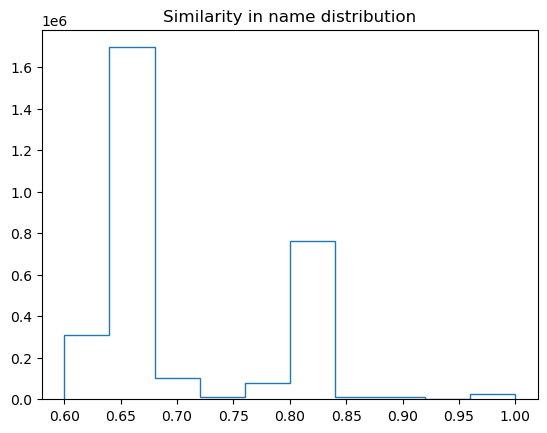

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

counts, bins =np.histogram(similarityname,range=[.6,1])
plt.stairs(counts, bins)
plt.title("Similarity in name distribution")
plt.show()



In [12]:
corpusaddress=pd.concat([tomatch.CleansedAddress,referential.CleansedAddress])
corpusaddress=corpusaddress.dropna()

In [13]:
#Based on the corpus of name we create a matrix of association
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizeraddress = CountVectorizer(strip_accents="ascii")
features = vectorizeraddress.fit(corpusaddress)

tomatchaddressvect=vectorizer.transform(tomatch.CleansedAddress)
referentialaddressvect=vectorizer.transform(referential.CleansedAddress)


# Renormalize so that if country is present twice in name and in country, it is counted only once

tomatchaddressvect=(tomatchaddressvect>0)*1
referentialaddressvect=(referentialaddressvect>0)*1


In [38]:
similarityaddress=cosine_similarity(tomatchaddressvect,referentialaddressvect)
globalsimilarity=similarityname*2+similarityaddress
argmaxglobalsimilarity=np.argmax(globalsimilarity,axis=1)

valuemaxglobalsimilarity=np.zeros(len(argmaxglobalsimilarity))
for i in range(len(argmaxglobalsimilarity)):
    valuemaxglobalsimilarity[i]=globalsimilarity[i,argmaxglobalsimilarity[i]]

for i in range(len(argmaxglobalsimilarity)):
    globalsimilarity[i,argmaxglobalsimilarity[i]]=0

secondargmaxglobalsimilarity=np.argmax(globalsimilarity,axis=1)
secondvaluemaxglobalsimilarity=np.zeros(len(secondargmaxglobalsimilarity))

for i in range(len(secondargmaxglobalsimilarity)):
    secondvaluemaxglobalsimilarity[i]=globalsimilarity[i,secondargmaxglobalsimilarity[i]]
secondvaluemaxglobalsimilarity


array([1.70710678, 2.        , 2.34519123, ..., 1.        , 1.76976911,
       3.        ])

In [39]:
# Pour le débug

premiereprop=[]
sdeprop=[]

ceilgreen=2.4
ceilamber=1.59
nbred=0
nbgreen=0
nbamber=0
matchrate=np.zeros(len(tomatch))

with open("proposition-master-supplier-debug.html", "w") as report_file:
    report_file.write("<head>")
    report_file.write("<style>")
    report_file.write(".green{background-color: #DAF7A6; }")
    report_file.write(".red{background-color:  #f7bccd ; }")
    report_file.write(".amber{background-color: #FFC300; }")
    report_file.write("</style>")
    report_file.write("<head>")
    report_file.write("<body>")
    report_file.write("<table>\n")
    report_file.write("<tr>\n")
    report_file.write("<th width=300>Name License Third party")
    report_file.write("</th>")
    report_file.write("<th width=400>Address License Third Party")
    report_file.write("</th>")
    report_file.write("<th width=300>Name Referential")
    report_file.write("</th>")
    report_file.write("<th width=400>Address Referential")
    report_file.write("</th>")
    report_file.write("<th width=30>Rating")
    report_file.write("</th>")
    report_file.write("<th width=30>Nature")
    report_file.write("</th>")
    report_file.write("</tr>")
    bestmatch=[]
    for i in range(len(tomatch)):
        idxtomatch=tomatch.iloc[i,:].name
        j=argmaxglobalsimilarity[i]
        rate=valuemaxglobalsimilarity[i]
        matchrate[i]=rate
        if rate>ceilgreen:
            style="green"
            nbgreen=nbgreen+1
        elif rate>ceilamber:
            style="amber"
            nbamber=nbamber+1
        else :
            style="red"
            nbred=nbred+1
        report_file.write("<tr class=\""+style+"\">\n")
        idxreferential=referential.iloc[j,:].name
        tupletpreferential=(idxtomatch,idxtomatch)
        bestmatch.append(tupletpreferential)
        report_file.write("<td rowspan=2>")
        report_file.write(tomatch.loc[idxtomatch,"NameCountryCleansed"])
        report_file.write("</td>")
        report_file.write("<td rowspan=2>")
        report_file.write(tomatch.loc[idxtomatch,"CleansedAddress"])
        report_file.write("</td>")
        report_file.write("<td>")
        report_file.write(referential.loc[idxreferential,"NameCountryCleansed"])
        report_file.write("</td>")
        report_file.write("<td>")
        report_file.write(referential.loc[idxreferential,"CleansedAddress"])
        report_file.write("</td>")
        report_file.write("<td>")
        report_file.write('{0:.2f}'.format(rate))
        report_file.write("</td>")
        report_file.write("<td rowspan=2>")
        report_file.write(str(tomatch.loc[idxtomatch,"nature"]))
        report_file.write("</td>")
        report_file.write("</tr>\n")

        j=secondargmaxglobalsimilarity[i]
        rate=secondvaluemaxglobalsimilarity[i]
        if rate>ceilgreen:
            style="green"
        elif rate>ceilamber:
            style="amber"
        else :
            style="red"
        report_file.write("<tr class=\""+style+"\">\n")
        idxreferential=referential.iloc[j,:].name
        report_file.write("<td>")
        report_file.write(referential.loc[idxreferential,"NameCountryCleansed"])
        report_file.write("</td>")
        report_file.write("<td>")
        report_file.write(referential.loc[idxreferential,"CleansedAddress"])
        report_file.write("</td>")
        report_file.write("<td>")
        report_file.write('{0:.2f}'.format(rate))
        report_file.write("</td>")
        report_file.write("</tr>\n")

    report_file.write("</table>\n")
    report_file.write("</body>\n")
    report_file.close()



<BarContainer object of 3 artists>

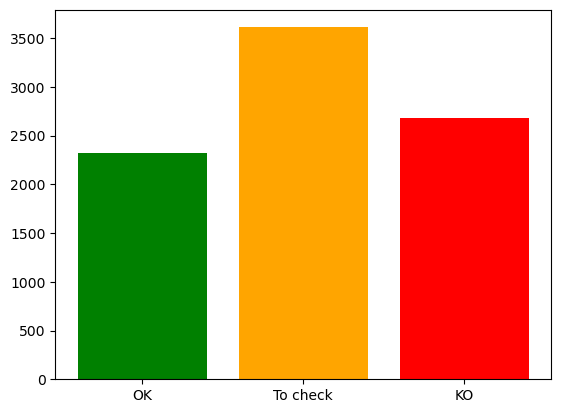

In [40]:
plt.bar(x=["OK","To check","KO"],height=[nbgreen,nbamber,nbred],color=['g','orange','r'])

In [30]:
mapnature={'1er destinataire': 'destinataire',
 'Foreign Consignee': 'destinataire',
 'Approved end user(s)': 'enduser',
 'Exportateur/Fournisseur': 'exportateur',
 'Destinataire final': 'destinataire',
 'Foreign Intermediate Consignee': 'destinataire',
 'client': 'client',
 'Approved End User(s)': 'enduser',
 'Demandeur': 'demandeur',
 'Party': 'party',
 'U.S. Consignor / Freight Forwarder': 'transport',
 'Client': 'client',
 'Foreign End User': 'enduser',
 'Exportateur': 'exportateur',
 'Intermediate Consignee': 'destinataire',
 'Ultimate Consignee': 'destinataire',
 'Control Authority': 'control',
 'Applicant': 'demandeur',
 'Supplier': 'exportateur',
 'Purchaser': 'acheteur',
 'Source of Commodity': 'exportateur',
 'Issuing Authority': 'control',
 'Intermediate Consignee(s)': 'destinataire',
 'Manufacturer of Commodity': 'exportateur',
 'Ausführer': 'exportateur',
 'Empfänger': 'destinataire',
 'Original Ultimate Consignee': 'destinataire',
 'U.S. Seller': 'exportateur',
 'Consignee': 'destinataire',
 'Aproved end user(s)': 'enduser',
 '1er Destinataire': 'destinataire',
 '1ers Destinataires': 'destinataire',
 'Destinataires finaux': 'destinataire',
 'Clients': 'client',
 '1er Destinataires': 'destinataire',
 'Intermédiaires': 'transport',
 'Intermédiaire': 'transport',
 '1er destiantaire': 'destinataire',
 'Agent/Vertreter': 'control',
 'Ausfürher': 'exportateur',
 'Importer': 'destinataire',
 '1ers destinataires': 'destinataire',
 'End User': 'enduser',
 'Control Authorithy': 'control',
 'Foreign Intermediate Consiegnee': 'destinataire',
 '1ers Detsinataires': 'destinataire',
 'Destinataire Final': 'destinataire',
 'Desinataire final': 'destinataire',
 '1er destinatiare': 'destinataire',
 'Exporter': 'exportateur',
 'Foreign Conseignee': 'destinataire',
 'Destinataires final': 'destinataire',
 'Agent Vertreter': 'control',
 'Destinataire': 'destinataire',
 'Foreign Buyer': 'acheteur'}

In [32]:
tomatch["nature"]=tp.TDPARTY_FLAG.map(mapnature)


In [46]:
tp=tp.TDPARTY_NAME.map(lambda x:x.lower())

0                                          entserv uk ltd
1                                    cti verwaltungs gmbh
2       liebherr-aerospace toulouse sas c/o bollore lo...
3                  esg elektroniksystem-und-logistik-gmbh
4                                                  airbus
                              ...                        
8609                                          bae systems
8610                               airbus operations gmbh
8611    ministry of defence saudi arabien militärische...
8612                                        wincanton plc
8613                               airbus operations gmbh
Name: TDPARTY_NAME, Length: 8614, dtype: object